<a href="https://colab.research.google.com/github/OliverWills/Yachts/blob/main/BERT_yachts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.7 MB/s eta 0:00:00


In [ ]:
# Import required packages
import os
import time
import datetime
import random
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from transformers import AdamW, BertModel, BertTokenizer, BertForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup

In [ ]:
# Mount Google Drive and read data from CSV file
drive.mount('/content/drive')
data = pd.read_csv("/content/drive/My Drive/yachts_cleaned.csv")

Mounted at /content/drive


In [ ]:
# Combine numerical data with text description and remove all but text and price columns
data['combined']="This is "+data['Title']+" yacht. It is located in "+data['Location']+". Tax status is "+data['Tax Status']+". It was built in "+data['Year'].astype(str)+". It has a length of "+data['Length_combined'].astype(str)+" meters. "+data['Description']
data = data[['Price_Adjusted','combined']]
# Drop missing values and extract descriptions
data=data.dropna()
descriptions=data['combined'].tolist()

1240


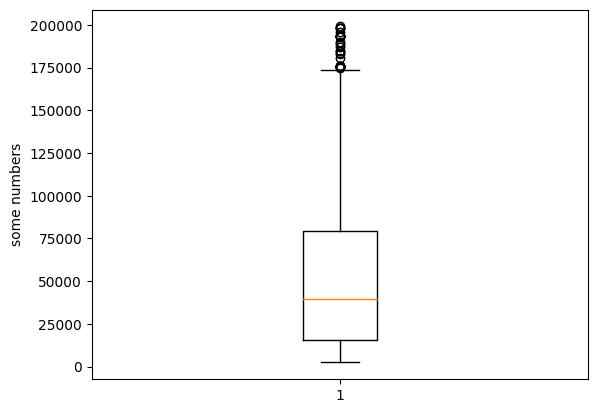

In [ ]:
import matplotlib.pyplot as plt
plt.boxplot(data['Price_Adjusted'])
plt.show()

In [ ]:
print(np.mean(data['Price_Adjusted']))

54848.71355488419


In [ ]:
print(np.median(data['Price_Adjusted']))

39600.0


<function matplotlib.pyplot.show(close=None, block=None)>

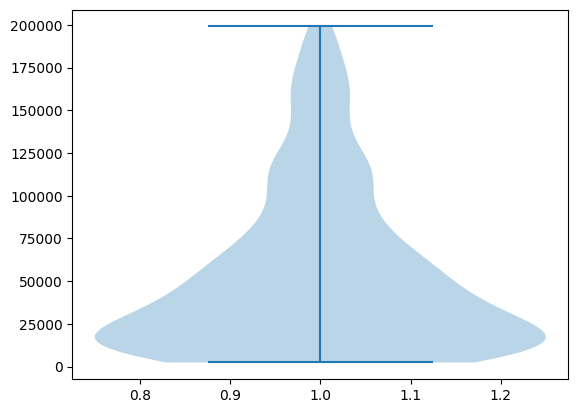

In [ ]:
plt.violinplot(data['Price_Adjusted'])
plt.show

In [ ]:
data=data[data['Price_Adjusted']<200000]

In [ ]:
descriptions=data['combined'].tolist()

In [ ]:
# train_size_int = int(0.8 * len(data))
# train_data, test_data = train_test_split(data, train_size=train_size_int,
#                                          random_state=42)
# df = train_data

In [ ]:
# Download and define tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# encode descriptions using tokenizer
encoded_corpus = tokenizer(text=descriptions,
  add_special_tokens=True,
  padding='max_length',
  truncation='longest_first',
  max_length=512,
  return_attention_mask=True)

In [ ]:
# Find the maximum length of a description
# max_len = 0

# for description in descriptions:
#     input_ids = tokenizer.encode(description, add_special_tokens=True)

#     max_len = max(max_len, len(input_ids))

# print('Max sentence length: ', max_len)

Max sentence length:  376


In [ ]:
# Filter out long descriptions greater than 512 tokens
def filter_long_descriptions(tokenizer, descriptions, max_len):
    indices = []
    lengths = tokenizer(descriptions, padding=False,
                     truncation=False, return_length=True)['length']
    for i in range(len(descriptions)):
        if lengths[i] <= max_len-2:
            indices.append(i)
    return indices

short_descriptions = filter_long_descriptions(tokenizer, descriptions, 512)
print(len(descriptions))
print(len(short_descriptions))
print(len(input_ids))

input_ids = np.array(input_ids)[short_descriptions]
attention_mask = np.array(attention_mask)[short_descriptions]
labels = data['Price_Adjusted'].to_numpy()[short_descriptions]

1240
1240


NameError: ignored

In [ ]:
# Define input ids and attention masks
input_ids = encoded_corpus['input_ids']
attention_mask = encoded_corpus['attention_mask']

input_ids = np.array(input_ids)
attention_mask = np.array(attention_mask)
labels = data['Price_Adjusted'].to_numpy()

In [ ]:
print(np.mean(labels))

54848.71355488419


In [ ]:
# Split train and test inputs and labels
test_size = 0.1
seed = 42
train_valid_inputs, test_inputs, train_valid_labels, test_labels = \
            train_test_split(input_ids, labels, test_size=test_size,
                             random_state=seed)

train_inputs, valid_inputs, train_labels, valid_labels = \
            train_test_split(train_valid_inputs, train_valid_labels, test_size=test_size,
                             random_state=seed)

train_valid_masks, test_masks, _, _ = train_test_split(attention_mask,
                                        labels, test_size=test_size,
                                        random_state=seed)

train_masks, valid_masks, _, _ = train_test_split(train_valid_masks,
                                        train_valid_labels, test_size=test_size,
                                        random_state=seed)

In [ ]:
print(np.mean(test_labels))

117608.21612903227


In [ ]:
# Scale labels (prices)
price_scaler = StandardScaler()
price_scaler.fit(train_labels.reshape(-1, 1))
train_labels = price_scaler.transform(train_labels.reshape(-1, 1))
valid_labels = price_scaler.transform(valid_labels.reshape(-1, 1))

In [ ]:
# Define and create train and test dataloaders
batch_size = 16
def create_dataloaders(inputs, masks, labels, batch_size):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    labels_tensor = torch.tensor(labels)
    dataset = TensorDataset(input_tensor, mask_tensor,
                            labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size,
                            shuffle=True)
    return dataloader

train_dataloader = create_dataloaders(train_inputs, train_masks,
                                      train_labels, batch_size)
test_dataloader = create_dataloaders(test_inputs, test_masks,
                                     test_labels, batch_size)
valid_dataloader = create_dataloaders(valid_inputs, valid_masks,
                                     valid_labels, batch_size)

In [ ]:
# The PyTorch code to implement this model is actually quite straightforward.
# Our CamembertRegressor is a PyTorch nn.Module with two new attributes:
    # an instance of the pretrained CamembertModel from the transformers library,
    # a single layer regression network taking as input a 768 long input and giving a single output value
# The forward method passes the tokenized input trough the CamembertModel and collects the 768 long vector corresponding
# to the “Class Label” output token. It then passes that vector through the regression layer that outputs the predicted value.

class BertRegressor(nn.Module):

    def __init__(self, drop_rate=0.2, freeze_bert=False):

        super(BertRegressor, self).__init__()
        D_in, D_out = 768, 1

        self.bert = \
                   BertModel.from_pretrained('bert-base-cased')
        self.regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(D_in, D_out))
    def forward(self, input_ids, attention_masks):

        outputs = self.bert(input_ids, attention_masks)
        class_label_output = outputs[1]
        outputs = self.regressor(class_label_output)
        return outputs
model = BertRegressor(drop_rate=0.2)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
model.to(device)

BertRegressor(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [ ]:
# Define the optimizer and the learning rate scheduler for our training process.
# We will use the Adam optimizer with a 5e-5 learning rate as was done in the official BERT paper.
optimizer = AdamW(model.parameters(),
                  lr=5e-5,
                  eps=1e-8)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# To define our scheduler, we must calculate the total number of training steps which is simply
# the number of training observations multiplied by the number of epochs.
# We will fine tune our model on 5 epochs.
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                 num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
# Loss function will be the Mean Squared Error loss, the most common loss function for regression problems.
loss_function = nn.MSELoss()

In [ ]:
# torch.cuda.empty_cache()
# %env PYTORCH_CUDA_ALLOC_CONF="256"
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = "max_split_size_mb:256"

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def evaluate(model, loss_function, test_dataloader, device):
    model.eval()
    test_loss, test_r2 = [], []
    for batch in test_dataloader:
        batch_inputs, batch_masks, batch_labels = \
                                 tuple(b.to(device) for b in batch)
        with torch.no_grad():
            outputs = model(batch_inputs, batch_masks)
        loss = loss_function(outputs, batch_labels)
        test_loss.append(loss.item())
        r2 = r2_score(outputs, batch_labels)
        test_r2.append(r2.item())
    return test_loss, test_r2

def r2_score(outputs, labels):
    labels_mean = torch.mean(labels)
    ss_tot = torch.sum((labels - labels_mean) ** 2)
    ss_res = torch.sum((labels - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [ ]:
def train(model, optimizer, scheduler, loss_function, epochs,
          train_dataloader, device, clip_value=2):

    # We'll store a number of quantities such as training and validation loss,
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()

    for epoch in range(epochs):
        # Perform one full pass over the training set.
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
        print('Training...')
        # Measure how long the training epoch takes
        t0 = time.time()
        # Reset the total loss for this epoch.
        total_train_loss = 0
        best_loss = 1e10
        model.train()
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 10 == 0 and not step == 0:
              elapsed = format_time(time.time() - t0)
              print(' Batch {:>5,} of {:>5,}. Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


            batch_inputs, batch_masks, batch_labels = \
                               tuple(b.to(device) for b in batch)
            model.zero_grad()
            outputs = model(batch_inputs, batch_masks)

            loss = loss_function(outputs.squeeze(),
                             batch_labels.squeeze().float())
            total_train_loss += loss.item()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(training_time))
        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        # model.eval()

        # Tracking variables
        # total_eval_accuracy = 0
        # total_eval_loss = 0
        # nb_eval_steps = 0

        # Evaluate data for one epoch
        # for batch in valid_dataloader:

            # Unpack this training batch from our dataloader.
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids
            #   [1]: attention masks
            #   [2]: labels
            # b_input_ids = batch[0].to(device)
            # b_input_mask = batch[1].to(device)
            # b_labels = batch[2].to(device)

            # batch_inputs, batch_masks, batch_labels = \
                               # tuple(b.to(device) for b in batch)
            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            # with torch.no_grad():

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here:
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                # (loss, logits) = model(b_input_ids,

                                     # attention_mask=b_input_mask,
                                     # labels=b_labels)
                # outputs = model(batch_inputs, batch_masks)
                # loss = loss_function(outputs.squeeze(),
                            # batch_labels.squeeze().float())
        valid_loss, valid_r2 = evaluate(model, loss_function, valid_dataloader, device)

            # Accumulate the validation loss.
        total_eval_loss = sum(valid_loss)

            # Move logits and labels to CPU
            # logits = logits.detach().cpu().numpy()
            # label_ids = batch_labels.to('cpu').numpy()




        # Report the final accuracy for this validation run.
        # avg_val_accuracy = total_eval_accuracy / len(valid_dataloader)
        avg_r2 = sum(valid_r2) / len(valid_dataloader)
        print("  Accuracy: {:}".format(avg_r2))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(valid_dataloader)

        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_r2,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

    return model

In [ ]:
# Helper function for formatting elapsed times as hh:mm:ss
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
model = train(model, optimizer, scheduler, loss_function, epochs,
              train_dataloader, device, clip_value=2)


======== Epoch 1 / 5 ========
Training...
 Batch    40 of    51. Elapsed: 0:00:58.

  Average training loss: 0.92
  Training epoch took: 0:01:13

Running Validation...


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  Accuracy: -38.00881085578621
  Validation Loss: 5214766988.12
  Validation took: 0:00:03

======== Epoch 2 / 5 ========
Training...
 Batch    40 of    51. Elapsed: 0:01:00.

  Average training loss: 0.63
  Training epoch took: 0:01:15

Running Validation...
  Accuracy: -32.60320002132969
  Validation Loss: 5661822304.91
  Validation took: 0:00:03

======== Epoch 3 / 5 ========
Training...
 Batch    40 of    51. Elapsed: 0:01:00.

  Average training loss: 0.49
  Training epoch took: 0:01:15

Running Validation...
  Accuracy: -34.70654405388082
  Validation Loss: 5466784803.60
  Validation took: 0:00:03

======== Epoch 4 / 5 ========
Training...
 Batch    40 of    51. Elapsed: 0:00:59.

  Average training loss: 0.23
  Training epoch took: 0:01:15

Running Validation...
  Accuracy: -35.14996041077728
  Validation Loss: 5537285755.30
  Validation took: 0:00:03

======== Epoch 5 / 5 ========
Training...
 Batch    40 of    51. Elapsed: 0:00:59.

  Average training loss: 0.16
  Training epo

In [ ]:
def predict(model, dataloader, device):
    model.eval()
    output = []
    for batch in dataloader:
        batch_inputs, batch_masks, _ = \
                                  tuple(b.to(device) for b in batch)
        with torch.no_grad():
            output += model(batch_inputs,
                            batch_masks).view(1,-1).tolist()[0]
    return output

In [ ]:
encoded_val_corpus = \
                tokenizer(text=test_inputs.tolist(),
                          add_special_tokens=True,
                          padding='max_length',
                          truncation='longest_first',
                          max_length=300,
                          return_attention_mask=True)

val_input_ids = np.array(encoded_val_corpus['input_ids'])
val_attention_mask = np.array(encoded_val_corpus['attention_mask'])
val_labels = val_set.prix.to_numpy()
val_labels = price_scaler.transform(val_labels.reshape(-1, 1))
val_dataloader = create_dataloaders(val_input_ids,
                         val_attention_mask, val_labels, batch_size)
y_pred_scaled = predict(model, val_dataloader, device)

In [ ]:
y_pred_scaled = predict(model, test_dataloader, device)

In [ ]:
# y_test = val_set.prix.to_numpy()
y_test = np.array(test_labels)
y_pred_scaled = np.array(y_pred_scaled)

y_pred = price_scaler.inverse_transform(y_pred_scaled.reshape(-1,1))

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
# mdape = ((pd.Series(y_test) - pd.Series(y_pred.reshape(-1,1)))\
        # / pd.Series(y_test)).abs().median()
r_squared = r2_score(y_test, y_pred)

In [ ]:
print(mae)
print(mdae)
print(mse)
print(mape)
print(r_squared)

54484.153621035126
32652.413426966206
5191595548.137844
597739.0633105658
-5842235796.834407


In [ ]:
import matplotlib.pyplot as plt

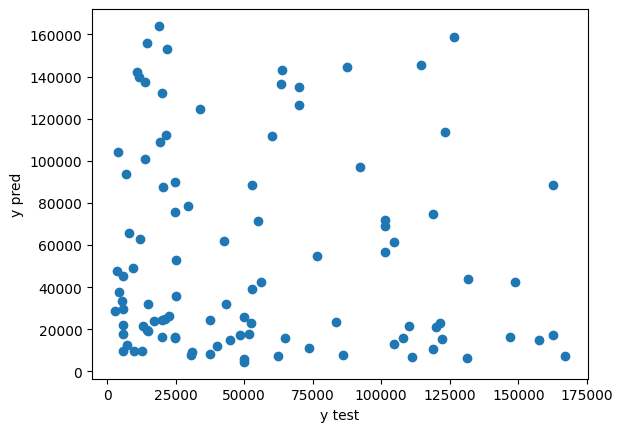

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel('y test')
plt.ylabel('y pred')
plt.show()

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


AttributeError: ignored

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(...)
tokenizer.save_pretrained('results/tokenizer/')

OSError: ignored

In [ ]:
output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

tokenizer.save_pretrained(output_dir)

('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json',
 './model_save/tokenizer.json')

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model.save_pretrained('results/tokenizer/')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
torch.save(model.state_dict(), model)

AttributeError: ignored